# Cluster analysis to determine countries in need of financial aid

# Table of Contents

* [About the dataset](#about)
     * [Description](#description)
     * [Data exploration](#exploration)
* [Data visualization](#visualization)
* [Pre-processing](#pca)
     * [Scaling](#scaling)
     * [Dimensionality reduction (PCA)](#norm)
* [K-means clustering](#ml)

<a id="about" ></a>
# About dataset

We will cluster countries using socio, economic and health factors (based on numerical features) in order to allocate funding for country's development. This considers unsupervised learning.

<a id="description" ></a>
# Description

## Features
- country : Name of the country
- child_mort : Death of children under 5 years of age per 1000 live births
- exports : Exports of goods and services per capita. Given as %age of the GDP per capita
- health : Total health spending per capita. Given as %age of GDP per capita
- imports : Imports of goods and services per capita. Given as %age of the GDP per capita
- Income : Net income per person
- Inflation : The measurement of the annual growth rate of the Total GDP
- life_expec : The average number of years a new born child would live if the current mortality patterns are to remain the same
- total_fer : The number of children that would be born to each woman if the current age-fertility rates remain the same
- gdpp : The GDP per capita. Calculated as the Total GDP divided by the total population.

<a id="exploration" ></a>
# Data exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

countries = pd.read_csv('../input/unsupervised-learning-on-country-data/Country-data.csv')
countries.head()
countries_copy = countries.copy()

In [2]:
print("Shape: ", countries.shape, '\n'*2)
print("Columns: ", countries.columns, '\n'*2)

print("Information: ")
print(countries.info(), '\n'*2)

print("Description: ")
print(countries.describe())

Shape:  (167, 10) 


Columns:  Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object') 


Information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB
None 


Description: 
       child_mort     exports      health     imports         income  \
count  167.000000  167.000000  167.000000  167

- The mean values are generally > the median (50%), which means that the **distribution** of the data might be **positively skewed** (tail on the right side).

- The **IQR**, which is the spread of the middle 50% of data (calculated as the **difference between the 75th percentile (Q3) and the 25th percentile (Q1)**), suggests that there is a greater spread of values in the upper quartile of the distribution compared to the lower quartile (Q3 > Q1). In other words, **the data points are more densely concentrated towards the lower end of the range**, with a longer tail extending towards higher values (pattern typical of positively skewed distributions).

- **Outliers** often fall **below Q1 - 1.5 * IQR**, or **above Q3 + 1.5 * IQR**; there are values outside this range, which might be considered outliers; outliers are also identifiable because of the much larger values present (for eg. the max value) than the 75th percentile.

### Check for null values and duplicates

In [3]:
print("NULL VALUES: ", countries.isnull().sum(), '\n'*2)

print("DUPLICATES VALUES: ", countries.duplicated().sum())

NULL VALUES:  country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64 


DUPLICATES VALUES:  0


<Axes: >

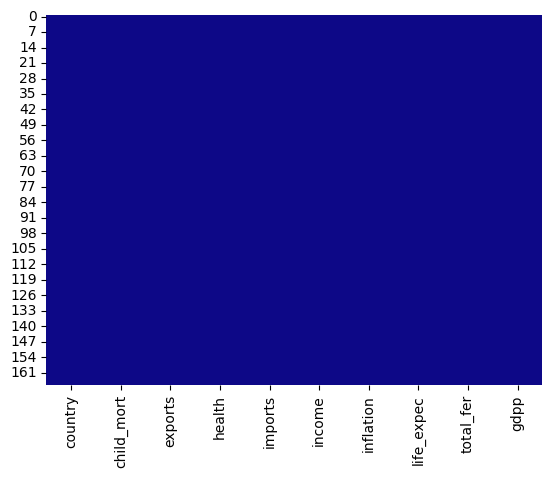

In [4]:
sns.heatmap(countries.isnull(), cmap = 'plasma', cbar = False) # I also removed color bar 

# potential values for cmap
# viridis, plasma, inferno, magma, coolwarm, jet, Greens, Blues, Reds, cividis

> There are no null values and duplicates.

In [5]:
columns = list(countries.columns)
columns.remove('country')

categorical_columns = ['country'] 
numerical_columns = [*columns] # create a list with all the remaining columns
# or num_columns = countries.select_dtypes(include = 'number').columns

# print the unpacked elements of the lists as separate arguments:
print('Categorical features: ', *categorical_columns)

# pass each element of numerical_columns list as a separate argument to the print() function
print('Numerical features: ', *numerical_columns)

Categorical features:  country
Numerical features:  child_mort exports health imports income inflation life_expec total_fer gdpp


### Correlation plot

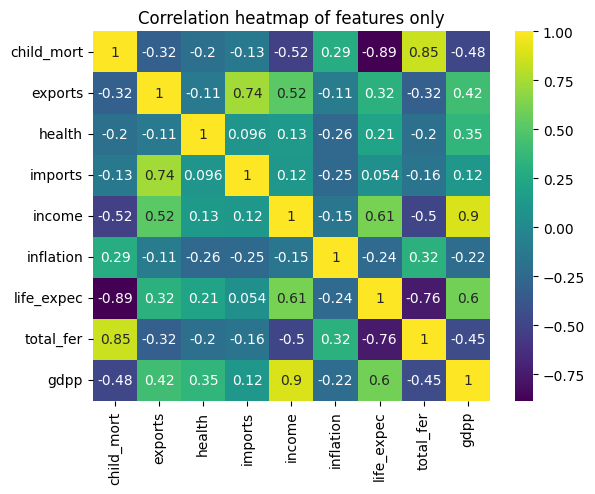

In [6]:
corr_matrix = countries.drop(columns = ['country']).corr()
sns.heatmap(corr_matrix, annot = True, cmap = 'viridis')

plt.title('Correlation heatmap of features only')
plt.show()

- High **positive correlations** between **total fertility** (the number of children that would be born to each woman if the current age-fertility rates remain the same) **& child mortality** (death of children under 5 years of age per 1000 live births), **imports & exports**, **income & exports**, **the GDP per capita & income**, **life expectancy & income**.
- There is also a slight positive correlation between the income and the child mortality.

<a id="visualization" ></a>
# Data visualization

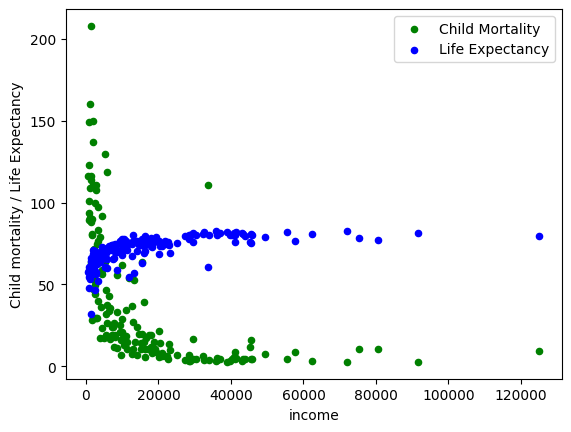

In [7]:
ax1 = countries.plot(kind = 'scatter', x = 'income', y = 'child_mort', color = 'g')
ax2 = countries.plot(kind = 'scatter', x = 'income', y = 'life_expec', color = 'b', ax = ax1) # ax = ax1 because the 2nd plot should be drawn on the same axis

plt.legend(labels = ['Child Mortality', 'Life Expectancy'])
plt.ylabel('Child mortality / Life Expectancy') 

plt.show()

- As expected, the death of children under 5 is correlated with the average number of years a new born child would live under the current mortality patterns. With an increase in income, both values increase.

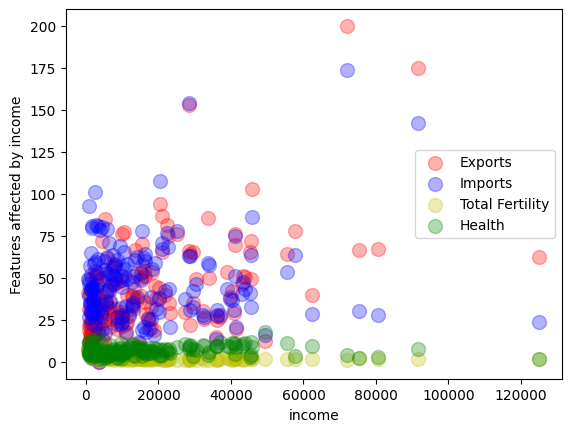

In [8]:
ax1 = countries.plot(kind = 'scatter', x = 'income', y = 'exports', color = 'r', label = 'Exports', alpha = 0.3, s = 100)
ax2 = countries.plot(kind = 'scatter', x = 'income', y = 'imports', color = 'b', label = 'Imports', ax = ax1, alpha = 0.3, s = 100)
ax3 = countries.plot(kind = 'scatter', x = 'income', y = 'total_fer', color = 'y', label = 'Total Fertility', ax = ax2, alpha = 0.3, s = 100)
ax4 = countries.plot(kind = 'scatter', x = 'income', y = 'health', color = 'g', label = 'Health', ax = ax3, alpha = 0.3, s = 100)

plt.ylabel('Features affected by income')
plt.legend()
plt.show()

- The poorer their health, the poorer in general (less income), women are less likely to give birth to children. Exports are also correlated with the total fertility and with low income, probably because of the lack of services provided to the communities. 
- Imports and exports are also strongly correlated, and both lead to increasing income.

### Data distribution across countries

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

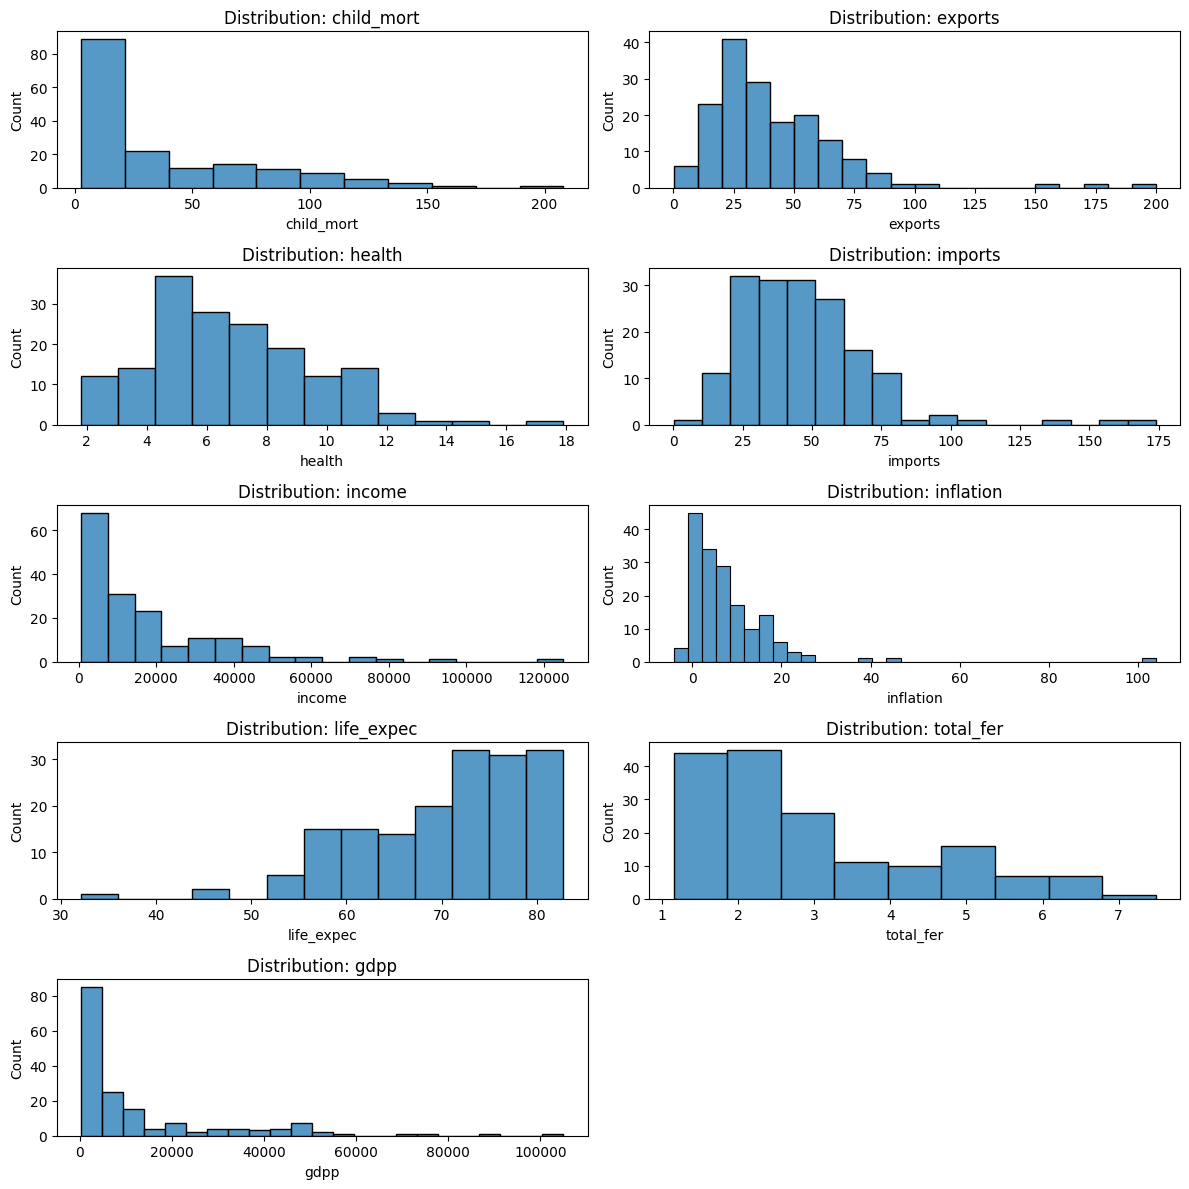

In [9]:
fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize = (12, 12))

# flatten the grid to make it easier to iterate over each subplot
# convert the 2D grid of subplots into a 1D array of subplots, where each element represents a subplot
ax = ax.flatten()

for i, column in enumerate(numerical_columns[ :9]):
    plt.subplot(5, 2, i+1)
    sns.histplot(countries[column])
    plt.title("Distribution: " + column)

# hide the last subplot because it's empty
ax[-1].axis('off')

# prevent overlapping by adjusting the subplots layout
plt.tight_layout()
plt.show()

- There are some outliers, but they may be relevant given the countries with critical conditions (so this is not noise).
- There are also some distributions with 2 peaks.

### Top countries by high and low wealth

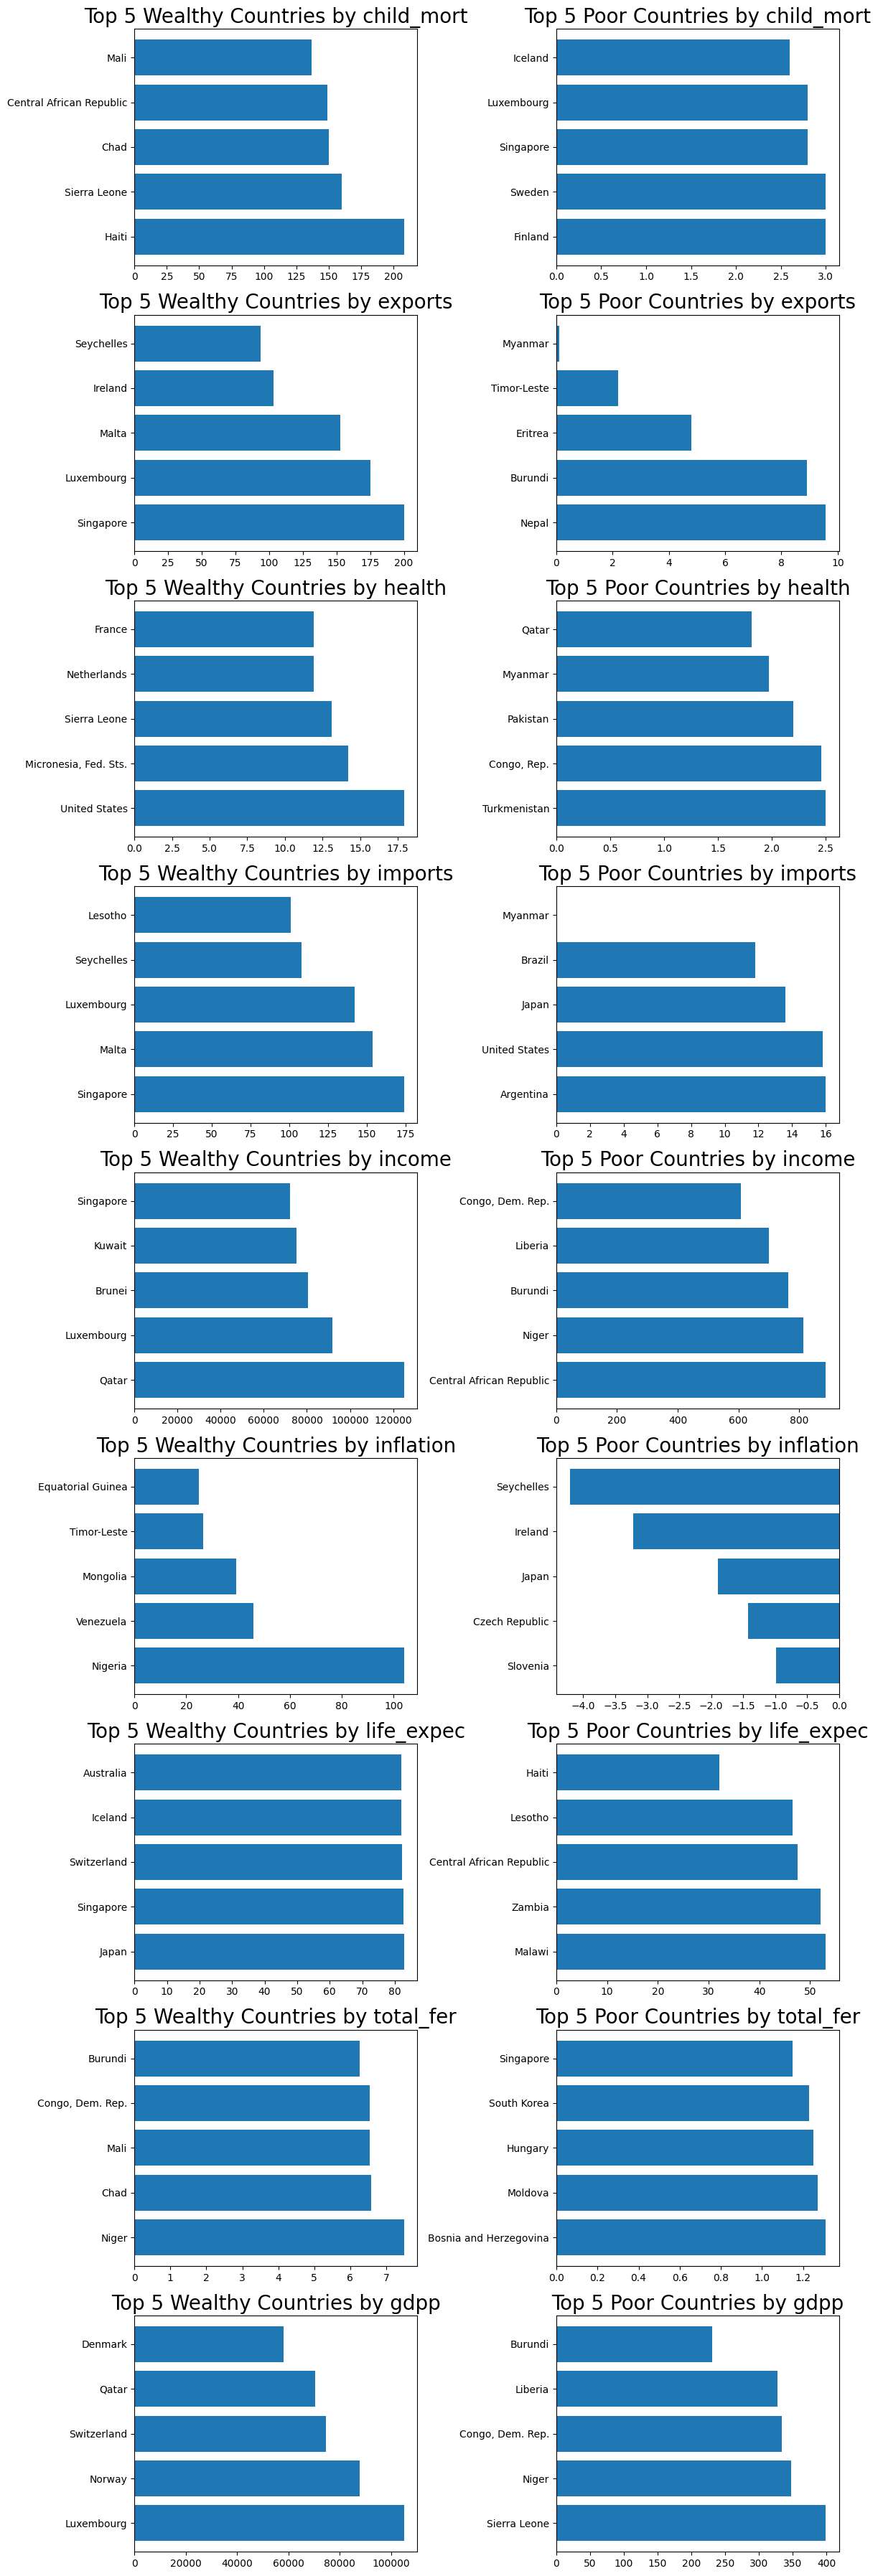

In [10]:
fig, ax = plt.subplots(nrows = 9, ncols = 2, figsize = (12, 4 * 9)) # 9 columns and 2 plots for each 

# iterate over each numerical column along with its index:
for i, column in enumerate(numerical_columns):
    sorted_countries = countries.sort_values(column, ascending = False)
    
    top_wealthy_countries = sorted_countries.head(5)
    top_poor_countries = sorted_countries.tail(5)
    
    ax[i, 0].barh(top_wealthy_countries['country'], top_wealthy_countries[column])
    ax[i, 0].set_title(f"Top 5 Wealthy Countries by {column}", fontsize = 20)

    ax[i, 1].barh(top_poor_countries['country'], top_poor_countries[column])
    ax[i, 1].set_title(f"Top 5 Poor Countries by {column}", fontsize = 20)


plt.tight_layout()
plt.show()

In [11]:
import plotly.express as px

countries_map = list(countries.drop('country', axis = 1))
countries_map   

['child_mort',
 'exports',
 'health',
 'imports',
 'income',
 'inflation',
 'life_expec',
 'total_fer',
 'gdpp']

In [12]:
for column in countries_map:
    fig = px.choropleth(countries,
                       locationmode = 'country names', 
                       locations = 'country',
                       color = column, #  the choropleth map is colored based on the current column being iterated over in the loop
                       title = 'Country by ' + column,
                       color_continuous_scale = 'Greens')
    
    fig.update_layout(paper_bgcolor = 'lightgrey')
    
    fig.show()

- As the bar plots showed, together with the above maps, we can conclude that the general wealthy countries are in North America and Europe, Africa shows the worst values and Asia seems well calibrated with usual values.

<a id="pca" ></a>
# Pre-procesing

- PCA, a dimensionality reduction technique, transforms the original features of the datset into a new set of orthogonal (uncorrelated) features called principal components. These are ordered by the amount of variance they explain in the data, with the first principal component explaining the most variance, the second explaining the second most, and so on.
- A PCA plot converts the correlations (or lack thereof) between the cells into a 2D graph.
- Cells that are highly correlated cluster together.
- The axes are ranked in the order of importance.
- When using k-means clustering, it is better to use standardization (or z-score normalization) rather than normalization because:
- K-means clustering is based on Euclidean distance (the distance between points is computed using the sum of squared differences between their feature values). Standardization scales the features to have zero mean and unit variance, which ensures that all features contribute equally to the distance calculation. This can lead to more balanced clusters and better clustering results.
- Standardized features have a more interpretable scale (mean of 0, standard deviation of 1), which makes it easier to interpret the clustering results and compare the importance of different features.
- Standardization preserves the relative distances between data points, which is important for k-means clustering algorithm. On the other hand, normalization changes the scale of individual samples but does not necessarily preserve the relative distances between them.
- To sum up, standardization centers the data around 0 and scales it by the standard deviation, while normalization scales individual samples to have unit norm (such that their lengths become 1).

> When scaling the data, we can either **normalize** or **standardize** it.

- Most algorithms assume that the data is **normally distributed** (Gaussian distribution), reason being **normalization** is done for **not normally distributed features.**
- Conversely, **standardization** is done for normally distributed features, whose **values** are **much higher/much smaller** compared to the others.

<a id="scaling" ></a>
# Scaling

- We are scaling the data so as to remove potential bias towards features with higher values because of their different (and incomparable) units.
- This variance may impact the performance of the k-means model, since it is based on computing distances, and it can give more weight to some features.
- **We will compare 2 scaling methods.**

In [13]:
# modify the df insomuch as countries name are dropped
countries.drop(['country'], axis = 1, inplace = True)

#### MinMax Scaler for normalization

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

columns = countries.columns

# fit function finds the x_min and x_max 
# transform function applies the scaling formula to the data
scaled_countries_minmax = scaler.fit_transform(countries)

df_scaled_minmax = pd.DataFrame(data = scaled_countries_minmax, columns = columns)
df_scaled_minmax

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242
...,...,...,...,...,...,...,...,...,...
162,0.129503,0.232582,0.213797,0.302609,0.018820,0.063118,0.609467,0.370662,0.026143
163,0.070594,0.142032,0.192666,0.100809,0.127750,0.463081,0.854043,0.208202,0.126650
164,0.100779,0.359651,0.312617,0.460715,0.031200,0.150725,0.808679,0.126183,0.010299
165,0.261441,0.149536,0.209447,0.197397,0.031120,0.257000,0.698225,0.555205,0.010299


#### Standard scaler for standardization

In [15]:
from sklearn.preprocessing import StandardScaler

columns = countries.columns

scaler = StandardScaler()

scaled_countries_standard = scaler.fit_transform(countries)

df_scaled_standard = pd.DataFrame(data = scaled_countries_standard, columns = columns)
df_scaled_standard

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817
...,...,...,...,...,...,...,...,...,...
162,-0.225578,0.200917,-0.571711,0.240700,-0.738527,-0.489784,-0.852161,0.365754,-0.546913
163,-0.526514,-0.461363,-0.695862,-1.213499,-0.033542,3.616865,0.546361,-0.316678,0.029323
164,-0.372315,1.130305,0.008877,1.380030,-0.658404,0.409732,0.286958,-0.661206,-0.637754
165,0.448417,-0.406478,-0.597272,-0.517472,-0.658924,1.500916,-0.344633,1.140944,-0.637754


#### Comparing scaling methods

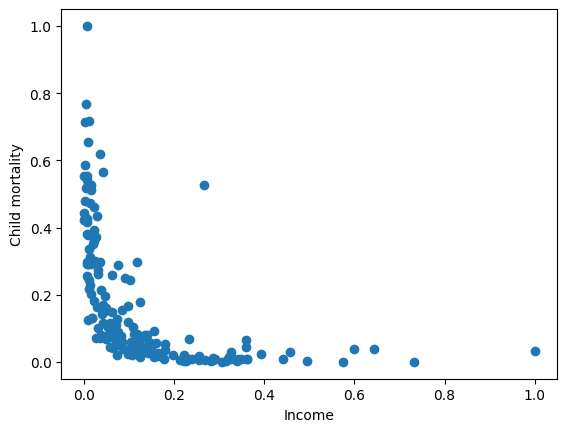

In [16]:
plt.scatter(df_scaled_minmax['income'], df_scaled_minmax['child_mort'])

plt.xlabel('Income')
plt.ylabel('Child mortality')
plt.show()

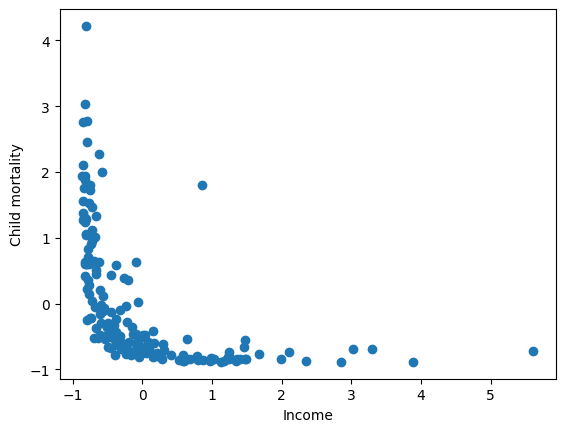

In [17]:
plt.scatter(df_scaled_standard['income'], df_scaled_standard['child_mort'])

plt.xlabel('Income')
plt.ylabel('Child mortality')
plt.show()

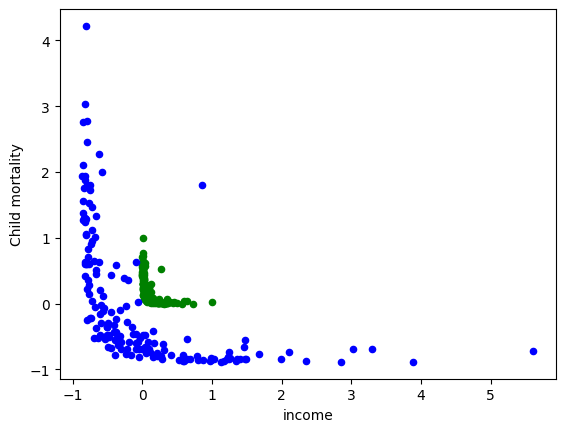

In [18]:
ax1 = df_scaled_minmax.plot(kind = 'scatter', x = 'income', y = 'child_mort', color = 'g')
ax2 = df_scaled_standard.plot(kind = 'scatter', x = 'income', y = 'child_mort', color = 'b', ax = ax1) 

plt.ylabel('Child mortality') 

plt.show()

- MinMaxScaler scales the data to a fixed range ([0, 1]), by subtracting the minimum value and then dividing by the range (i.e. maximum - minimum).
- StandardScaler standardizes the data by removing the mean. It scales to unit variance (the variance of the data is normalized to 1). It transforms the data such that it has a mean of 0 and a standard deviation of 1. It does not bound the features to a specific range.

<a id="norm" ></a>
# PCA (principal component analysis)

#### PCA with data scaled with MinMaxScaler

Text(0.5, 1.0, 'Scree plot')

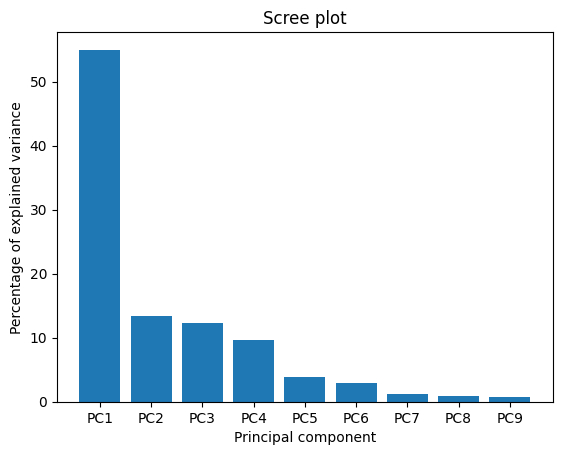

In [19]:
from sklearn.decomposition import PCA

# create a PCA object
pca = PCA()

# analyze the structure of the data and transform it
# transform method applies the learned transformation to the data, resulting in a new dataset with reduced dimensions 
pca.fit(df_scaled_minmax)
pca_data_minmax = pca.transform(df_scaled_minmax)

# calculate the percentage of variance explained by each principal component
# and round the percentage values to one decimal place
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals = 1)

# create labels for principal components
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]

# plot the % of explained variance by principal components
plt.bar(x = range(1, len(per_var) + 1),    # principal component numbers as the x-axis 
        height = per_var,                  # percentage of explained variance for each principal component
        tick_label = labels)               # assigns labels to the x-axis ticks, which are the names of the principal components ('PC1', 'PC2')

plt.ylabel('Percentage of explained variance')
plt.xlabel('Principal component')
plt.title('Scree plot')

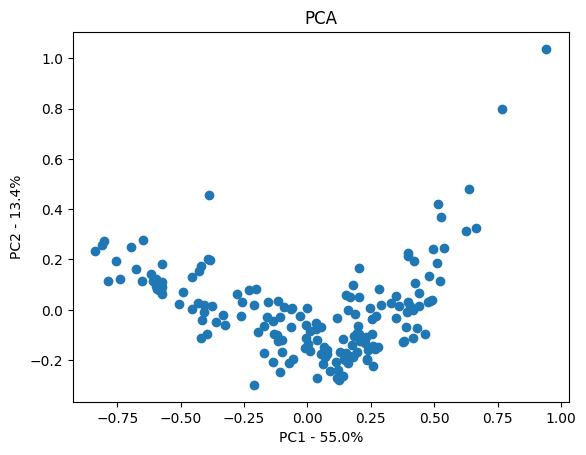

In [20]:
# plot to visualize the principal components
pca_df_minmax = pd.DataFrame(pca_data_minmax, columns = labels)
plt.scatter(pca_df_minmax.PC1, pca_df_minmax.PC2)
plt.title('PCA')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
plt.show()

#### PCA with data scaled with StandardScaler

Text(0.5, 1.0, 'Scree plot')

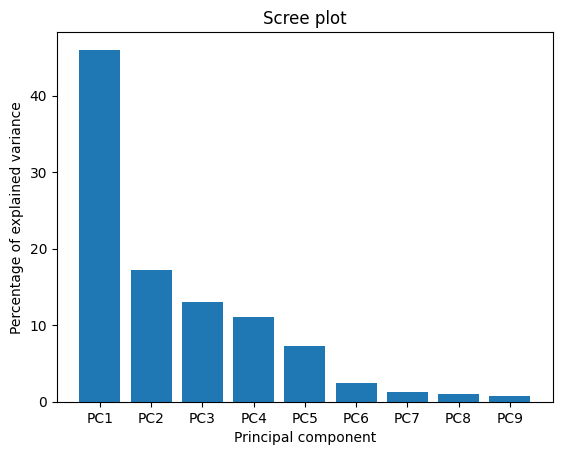

In [21]:
pca = PCA()

pca.fit(df_scaled_standard)
pca_data_standard = pca.transform(df_scaled_standard)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals = 1)

labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]

plt.bar(x = range(1, len(per_var) + 1), height = per_var, tick_label = labels)   
plt.ylabel('Percentage of explained variance')
plt.xlabel('Principal component')
plt.title('Scree plot')

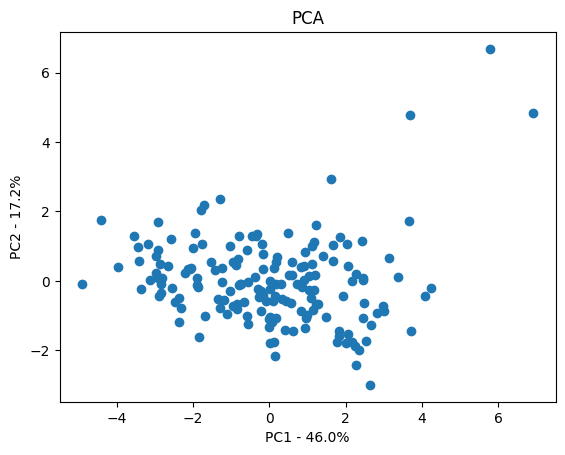

In [22]:
pca_df_standard = pd.DataFrame(pca_data_standard, columns = labels)
plt.scatter(pca_df_standard.PC1, pca_df_standard.PC2)
plt.title('PCA')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
plt.show()

#### Dataframe with principal components 1-5

In [23]:
five_components = pca_df_standard.drop(['PC6', 'PC7', 'PC8', 'PC9'], axis = 1)
five_components

,PC1,PC2,PC3,PC4,PC5
0,-2.913025,0.095621,-0.718118,1.005255,-0.158310
1,0.429911,-0.588156,-0.333486,-1.161059,0.174677
2,-0.285225,-0.455174,1.221505,-0.868115,0.156475
3,-2.932423,1.695555,1.525044,0.839625,-0.273209
4,1.033576,0.136659,-0.225721,-0.847063,-0.193007
...,...,...,...,...,...
162,-0.820631,0.639570,-0.389923,-0.706595,-0.395748
163,-0.551036,-1.233886,3.101350,-0.115311,2.082581
164,0.498524,1.390744,-0.238526,-1.074098,1.176081
165,-1.887451,-0.109453,1.109752,0.056257,0.618365


In [24]:
explained_variance_ratios = pca.explained_variance_ratio_
principal_components = []

# create label for each pc
for i in range (1, 10):
    principal_components.append(f'PC{i}')

df_explained_variance_ratios = pd.DataFrame({'PC': principal_components, 
                                             'explained_variance_ratio': explained_variance_ratios})

df_explained_variance_ratios['Cumulative_variance'] = df_explained_variance_ratios['explained_variance_ratio'].cumsum()  # cumulative sum of the evr

df_explained_variance_ratios

,PC,explained_variance_ratio,Cumulative_variance
0,PC1,0.459517,0.459517
1,PC2,0.171816,0.631334
2,PC3,0.130043,0.761376
3,PC4,0.110532,0.871908
4,PC5,0.073402,0.945310
5,PC6,0.024842,0.970152
6,PC7,0.012604,0.982757
7,PC8,0.009813,0.992569
8,PC9,0.007431,1.000000


> We can see that out of the all PCA generated using both standardised and normalised versions of the data, there are 4 that explain about 90% of the distribution of the original countries data.
- the first 2 pc have the best variances (PC1 - 46%, PC2 - 17%)

<a id="ml" ></a>
# K-means clustering

- K-means clustering algorithm is particularly useful when dealing, for example, with medical data, where we have tests results done but the conditions are unknown.
- This is the common algorithm used for unsupervised learning, that works, for the sake of theoretical example, on these principles:
    1. select the no. of clusters you want to identify in your data (k)
    2. randomly select 3 distinct data points (the initial clusters)
    3. measure the distance between the first point and the 3 initial clusters
    4. assign the first point to the nearest cluster
    5. the same thing for the next points 
    6. once all the points are in clusters, calculate the MEAN of each cluster; then measure and cluster using the mean values 
    7. if the cluster didn't change at all during the last iteration, we're done
    8. if the k-means clustering is terrible compared to what we did by eye, we can ASSESS the quality of the clustering by ADDING UP THE VARIATION WITHIN EACH CLUSTER.

#### Decide the number for k (clusters)

##### Elbow method

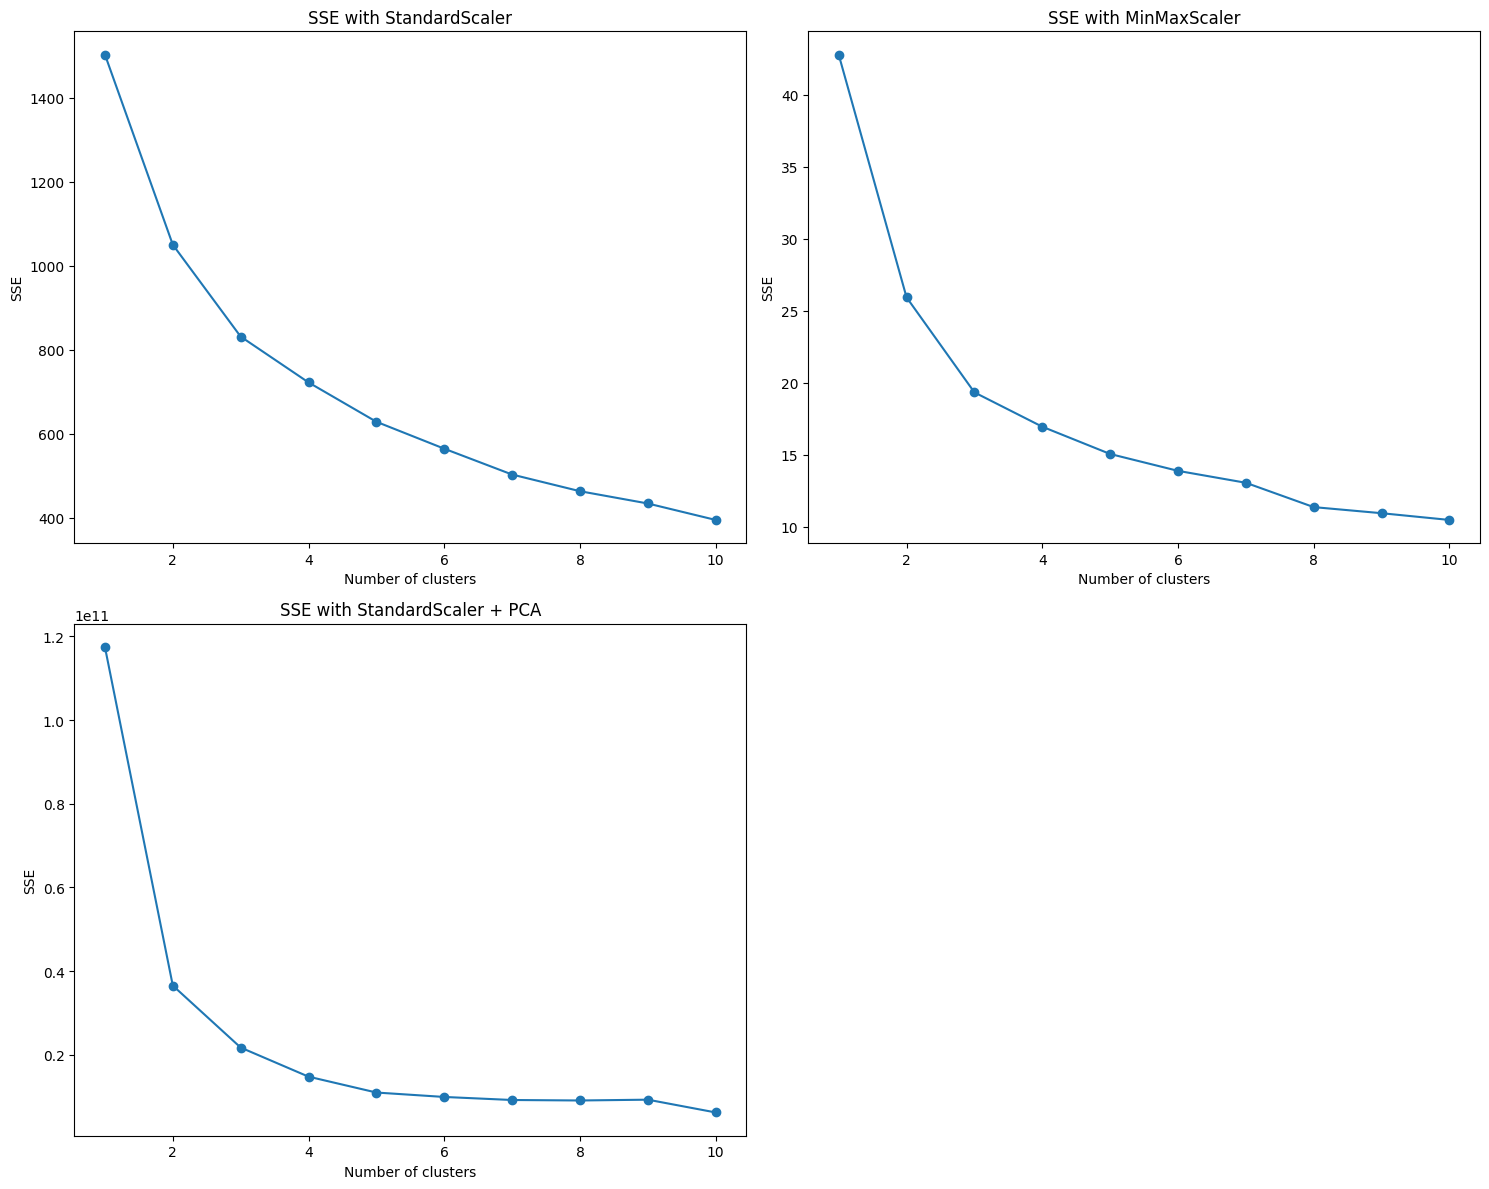

In [25]:
from sklearn.cluster import KMeans

# create subplots
fig, axs = plt.subplots(2, 2, figsize = (15, 12))

# calculate SSE for StandardScaler
sse_standard = []   # store the SSE values for different numbers of clusters

# iterate over a no. of clusters
for i in range(1, 11):
    km = KMeans(
        n_clusters = i, 
        init = 'random',   # initialize the centroids
        n_init = 10,       # number of times the KMeans algorithm will be run with different centroid seeds
        max_iter = 300,    # maximum number of iterations for each KMeans run
        tol = 1e-04,       # relative tolerance with respect to inertia to declare convergence = the threshold for determining when the algorithm has converged and should stop iterating
        random_state = 0
    )
    km.fit(df_scaled_standard)         # cluster the data points into i clusters based on their distances to the centroids
    sse_standard.append(km.inertia_)   # retrieve the SSE of the clusters
    
# the SSE = the sum of squared distances of data points to their nearest cluster centers (centroids)

# plot SSE for StandardScaler
axs[0, 0].plot(range(1, 11), sse_standard, marker = 'o')
axs[0, 0].set_xlabel('Number of clusters')
axs[0, 0].set_ylabel('SSE')
axs[0, 0].set_title('SSE with StandardScaler')

# calculate SSE for MinMaxScaler
sse_minmax = []
for i in range(1, 11):
    km = KMeans(
        n_clusters = i, 
        init = 'random',
        n_init = 10,
        max_iter = 300,
        tol = 1e-04, 
        random_state = 0
    )
    km.fit(df_scaled_minmax)
    sse_minmax.append(km.inertia_)

# plot SSE for MinMaxScaler
axs[0, 1].plot(range(1, 11), sse_minmax, marker = 'o')
axs[0, 1].set_xlabel('Number of clusters')
axs[0, 1].set_ylabel('SSE')
axs[0, 1].set_title('SSE with MinMaxScaler')

# calculate SSE for StandardScaler + PCA
sse_pca = []
for i in range(1, 11):
    km = KMeans(
        n_clusters = i,
        init = 'random',
        n_init = 10,
        max_iter = 300,
        tol = 1e-04, 
        random_state = 0
    )
    km.fit(countries)
    sse_pca.append(km.inertia_)

# Plot SSE for StandardScaler + PCA
axs[1, 0].plot(range(1, 11), sse_pca, marker = 'o')
axs[1, 0].set_xlabel('Number of clusters')
axs[1, 0].set_ylabel('SSE')
axs[1, 0].set_title('SSE with StandardScaler + PCA')

# hide the empty subplot
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()


In [26]:
pip install fuzzy-c-means

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.2/150.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.3 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.9.0
    Uninstalling typer-0.9.0:
      Successfully uninstalled typer-0.9.0
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.5.3
    Uninstalling pydantic-2.5.3:
      Successfully uninstalled pydantic-2.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which 

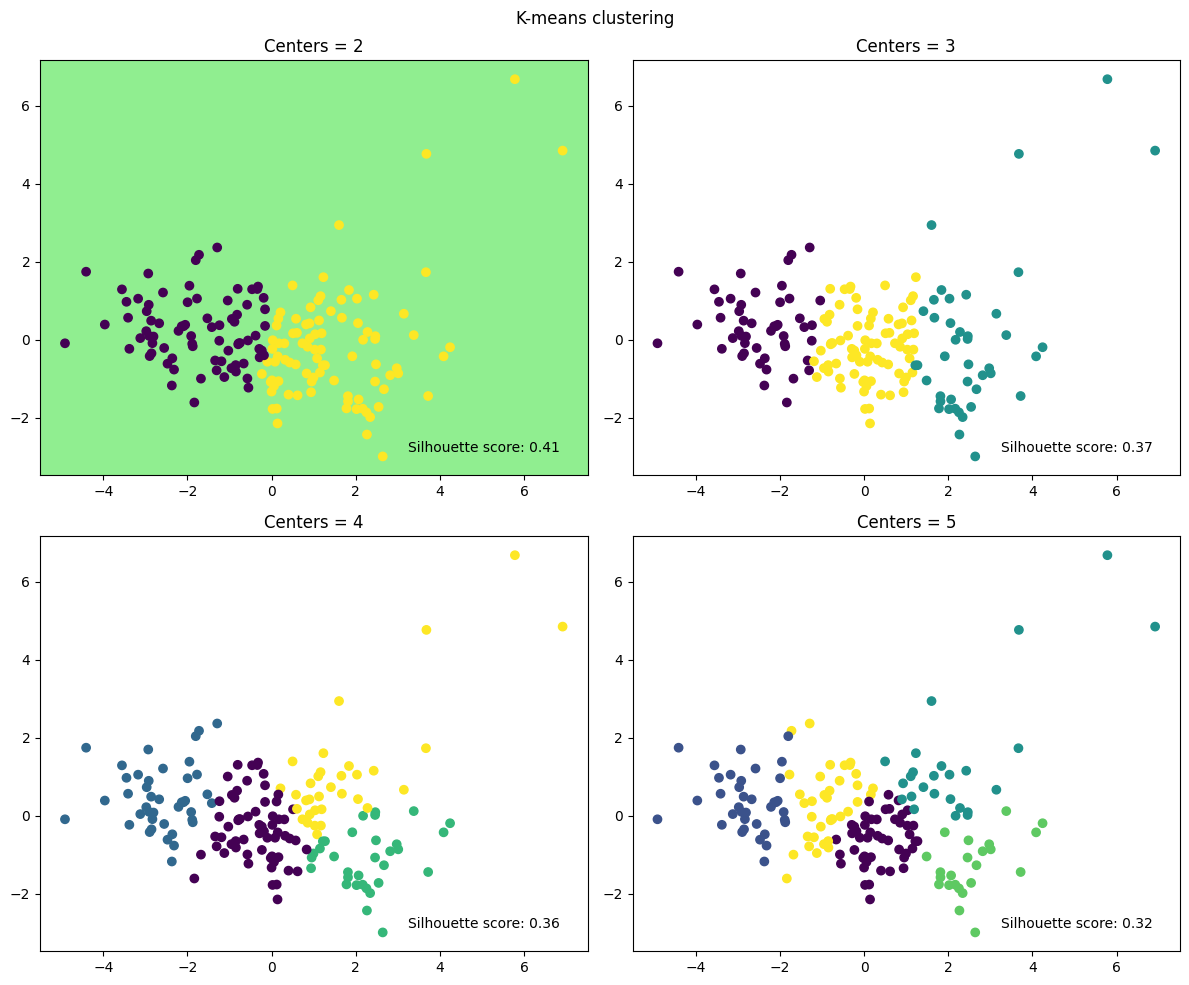

Best number of clusters based on silhouette score: 2


In [27]:
from fcmeans import FCM
from sklearn.metrics import silhouette_score

pca_ = pca_df_standard[['PC1', 'PC2']].values 

# compute cluster labels with Fuzzy C-means clustering
label = []
num_cluster = [2, 3, 4, 5]

for i in range(len(num_cluster)):
    fcm = FCM(n_clusters = num_cluster[i])
    fcm.fit(pca_)
    fcm.predict(pca_)
    label.append(fcm.predict(pca_))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (12, 10))
fig.suptitle('K-means clustering')

# plot clusters with different numbers of centers
ax_list = [ax1, ax2, ax3, ax4]
centers_list = [2, 3, 4, 5]
best_num_clusters = None
best_silhouette_score = -1

for ax, centers in zip(ax_list, centers_list):
    ax.scatter(pca_df_standard['PC1'], pca_df_standard['PC2'], c = label[centers - 2])
    ax.set_title(f'Centers = {centers}')

    # calculate silhouette score for the current number of clusters
    silhouette_avg = silhouette_score(pca_df_standard[['PC1', 'PC2']], label[centers - 2])

    # display silhouette score on the plot
    ax.text(0.95, 0.05, f'Silhouette score: {silhouette_avg:.2f}', transform = ax.transAxes, ha = 'right', va = 'bottom')

    # update best number of clusters if silhouette score is higher
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_num_clusters = centers

# highlight the subplot with the best number of clusters
for ax in ax_list:
    if 'Centers = {}'.format(best_num_clusters) in ax.get_title():
        ax.set_facecolor('lightgreen')

plt.tight_layout()
plt.show()

print(f'Best number of clusters based on silhouette score: {best_num_clusters}')


- It seems that the best number for k is between 2 and 4, and I will chose k = 3.

In [28]:
km = KMeans (
    n_clusters = 3, 
    init = 'random', 
    n_init = 10,
    max_iter = 300, 
    tol = 1e-4, 
    random_state = 0
)

# normalised dataset
# compute the clusters and assign the labels
y_predicted_minmax = km.fit_predict(df_scaled_minmax) # fit_predict computes cluster centers and predict cluster index for each sample.

# standardised dataset
# compute the clusters and assign the labels
y_predicted_standard = km.fit_predict(df_scaled_standard) 

# original dataset with standard scaling and 4 principal components found with PCA
four_pca = pca_df_standard.drop(['PC5','PC6','PC7','PC8','PC9'], axis = 1)
y_predicted_pca = km.fit_predict(four_pca) 

In [29]:
# add the cluster column to the dataframe 
df_scaled_minmax['cluster'] = y_predicted_minmax
df_scaled_standard['cluster'] = y_predicted_standard
countries['cluster'] = y_predicted_pca

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/

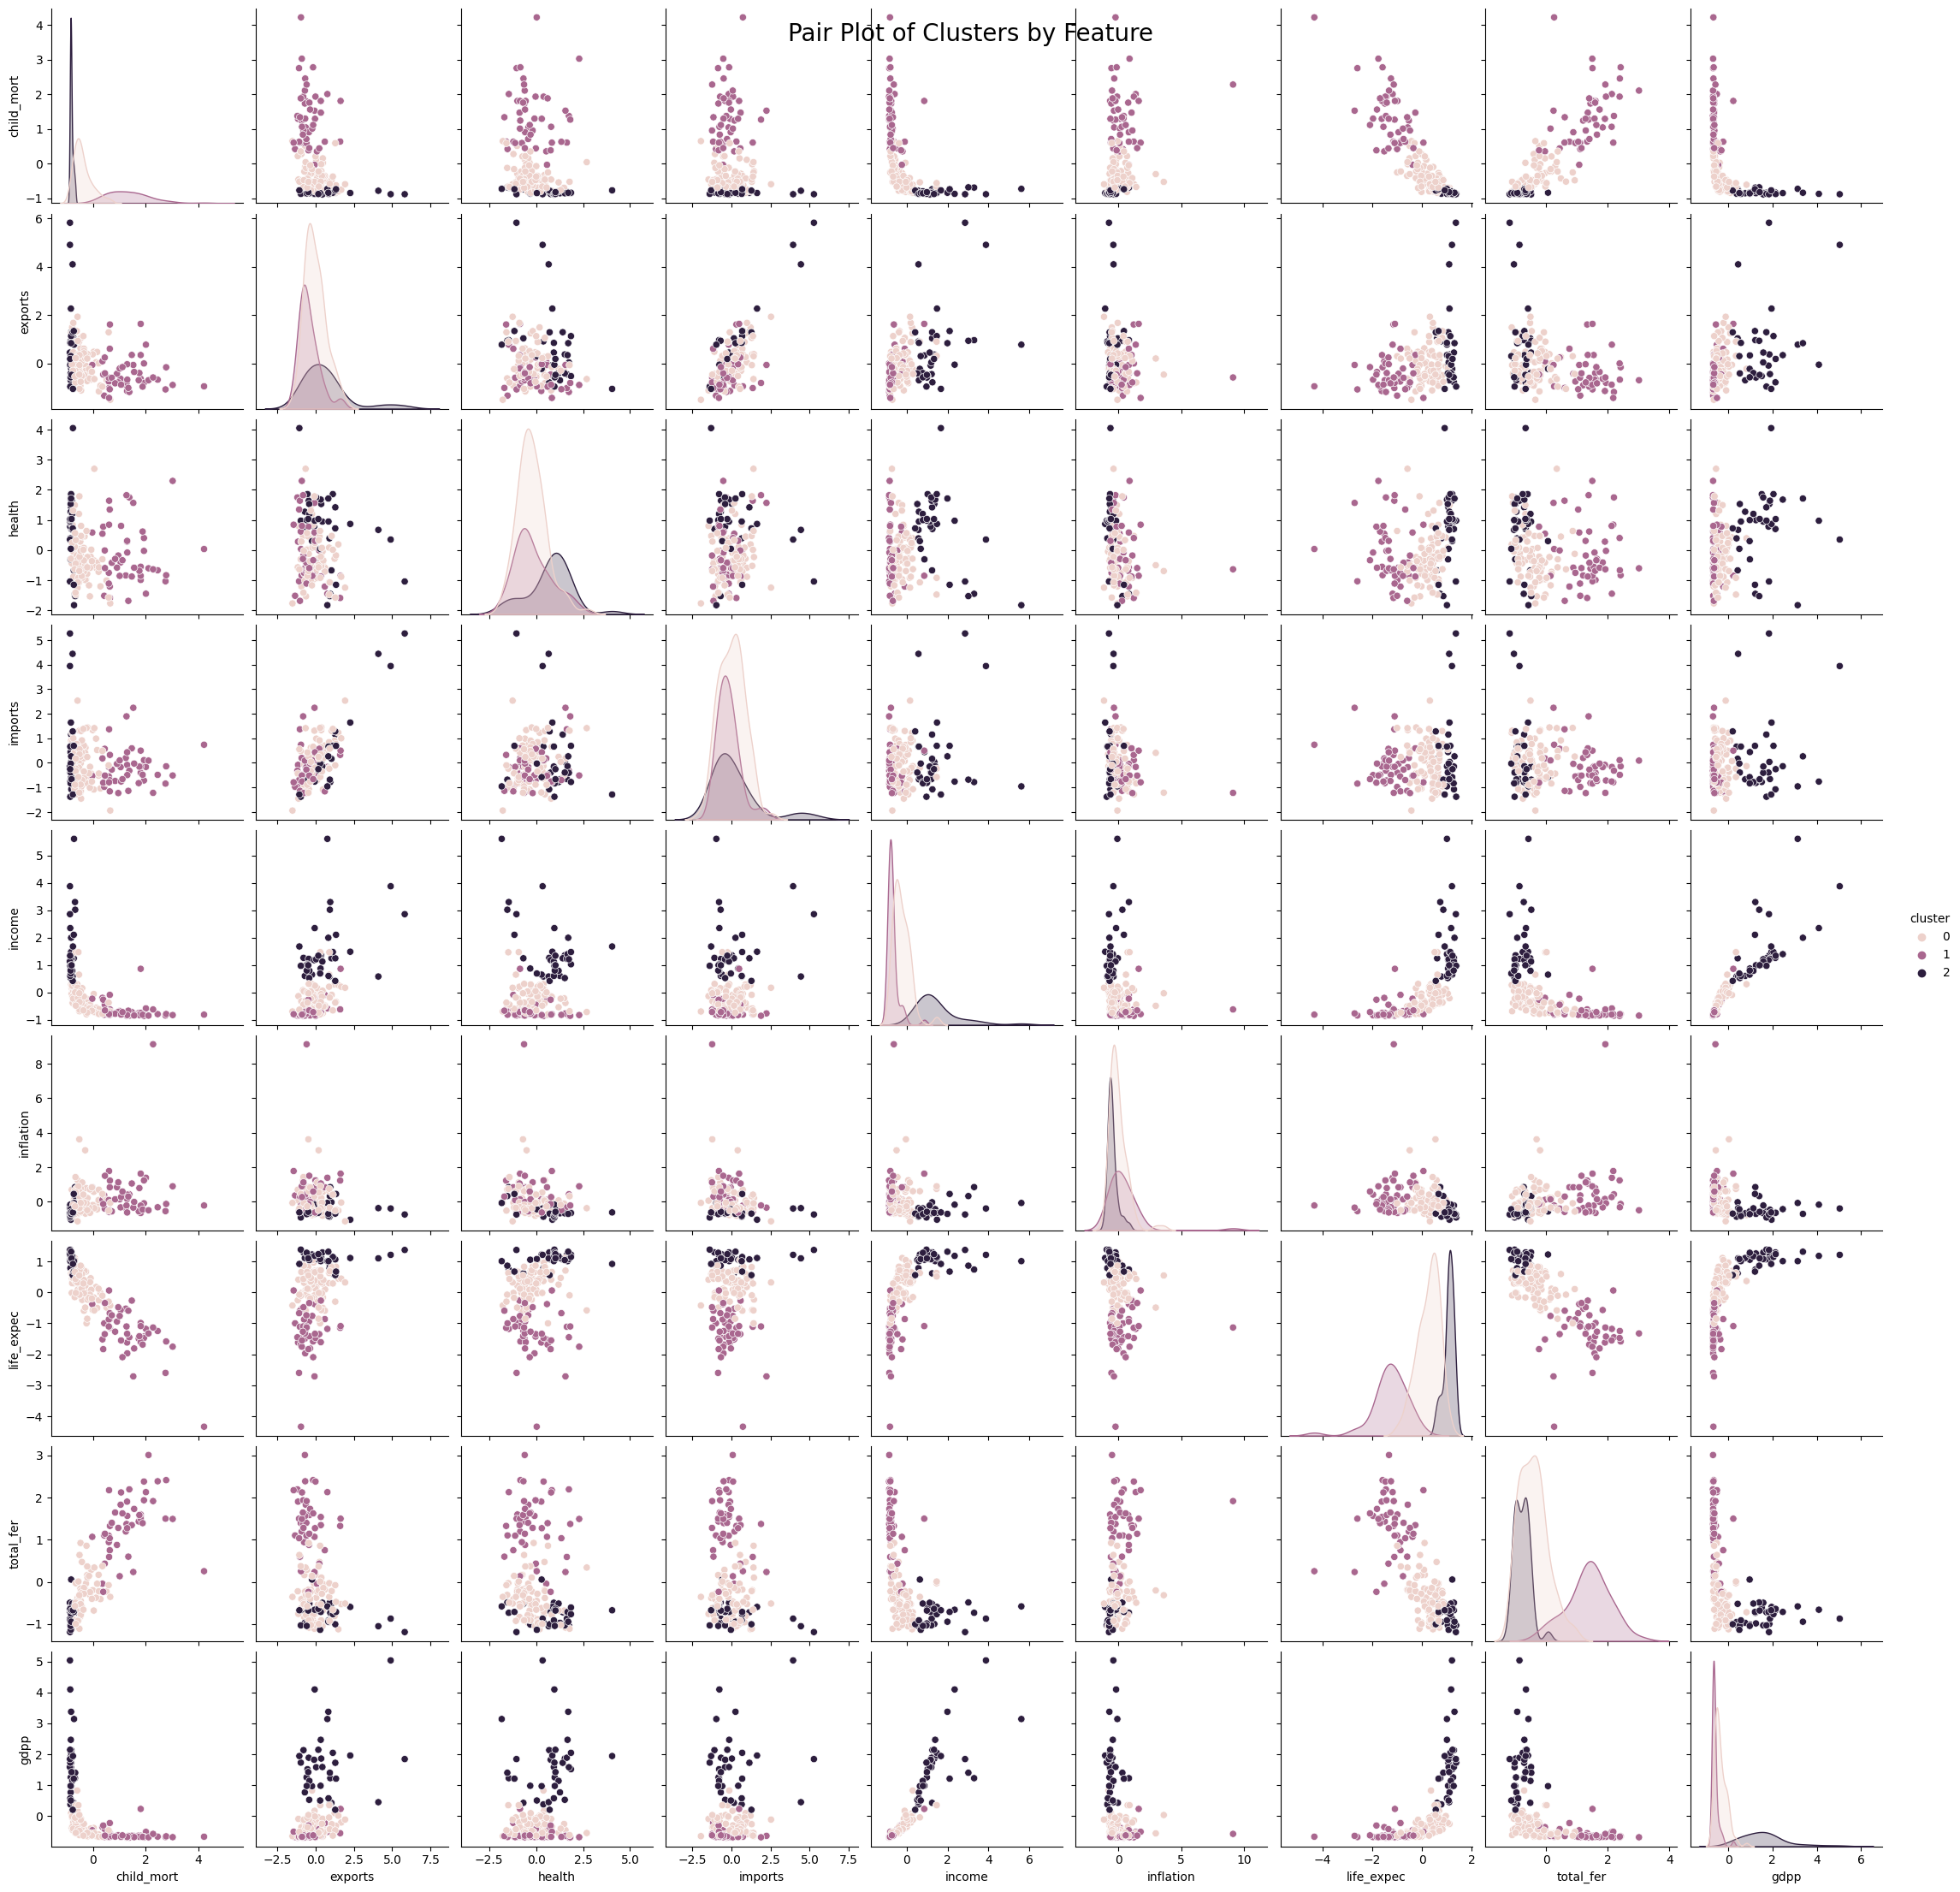

In [30]:
sns.get_dataset_names() # load example dataset from seaborn 

sns.load_dataset('penguins')
sns.pairplot(df_scaled_standard, hue = "cluster")

plt.suptitle('Pair Plot of Clusters by Feature', size = 20);
plt.show()